<a href="https://colab.research.google.com/github/m0zzarella/MRI_ViT_Alz/blob/main/Vanilla_ViT_Pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
from PIL import Image
import numpy as np

In [3]:
root_path = "/content/drive/MyDrive/Alzheimers_Classify/Alzheimers_Classify"

In [4]:
ad_data = os.path.join(root_path, 'AD')
cn_data = os.path.join(root_path, 'CN')

In [5]:
'''slight preprocessing and data ready'''
import concurrent.futures
from tqdm.notebook import tqdm

def load_image(image_file):
    image = Image.open(image_file).convert('L')
    return np.array(image)

def prepare_folders(folder):
    images = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for sub_folder in os.listdir(folder):
            sub_folder_path = os.path.join(folder, sub_folder)
            if os.path.isdir(sub_folder_path):
                image_files = glob.glob(os.path.join(sub_folder_path, '*.*'))

                images.extend(list(executor.map(load_image, image_files)))
    return images


ad_images = prepare_folders(ad_data)
cn_images = prepare_folders(cn_data)

dataset = ad_images + cn_images

dataset = np.array(dataset)

print(f"Total images: {len(dataset)}")

Total images: 4379


In [11]:
print(f"Number of AD images: {len(ad_images)}")
print(f"Number of CN images: {len(cn_images)}")
print(f"Total images: {len(dataset)}")

Number of AD images: 1998
Number of CN images: 2381
Total images: 4379


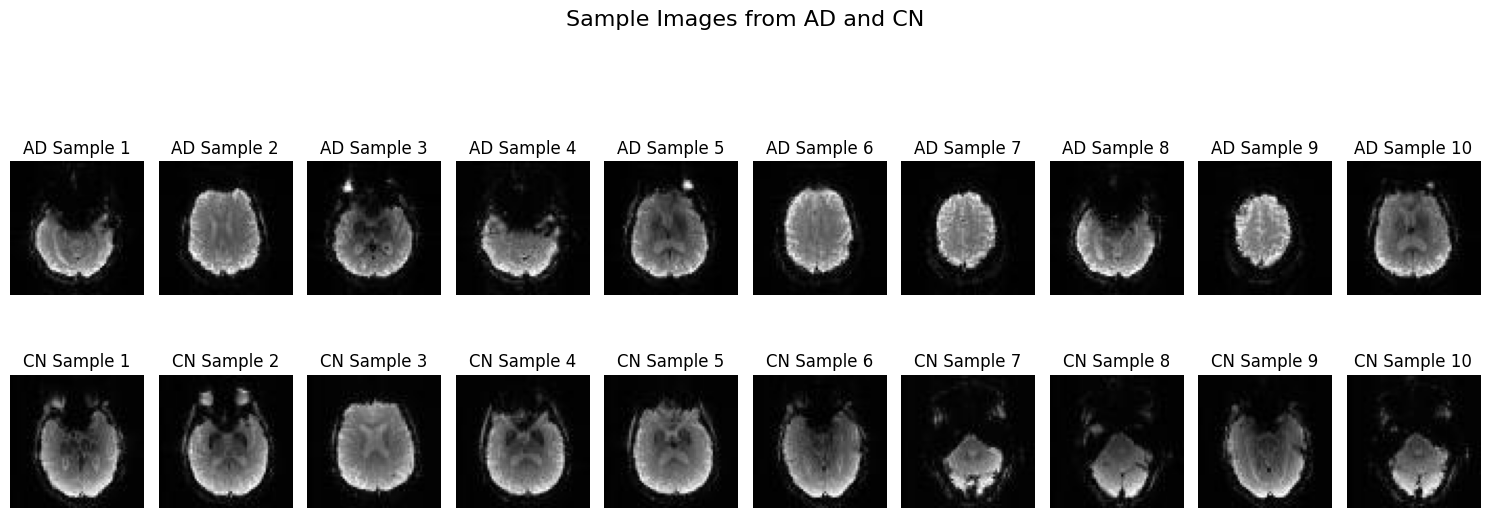

In [12]:
'''visualise some of the data'''
import matplotlib.pyplot as plt

num_samples = 10

fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
fig.suptitle('Sample Images from AD and CN', fontsize=16)


for i in range(num_samples):
    axes[0, i].imshow(ad_images[i], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'AD Sample {i+1}')

for i in range(num_samples):
    axes[1, i].imshow(cn_images[i], cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'CN Sample {i+1}')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [13]:
ad_labels = np.zeros(len(ad_images), dtype=int)
cn_labels = np.ones(len(cn_images), dtype=int)

In [14]:
images = np.array(ad_images + cn_images)
labels = np.concatenate([ad_labels, cn_labels])

shuffle_idx = np.random.permutation(len(images))
images = images[shuffle_idx]
labels = labels[shuffle_idx]

In [15]:
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


dataset = CustomImageDataset(images, labels, transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset size: {train_size}, Validation dataset size: {val_size}, Test dataset size: {test_size}")

Train dataset size: 3065, Validation dataset size: 875, Test dataset size: 439


In [17]:
import torchvision.models as models

model = models.vit_b_16(pretrained=True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 139MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [22]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

model = models.vit_b_16(pretrained=True)

num_classes = 2

current_head = model.heads[0]
new_head = nn.Linear(current_head.in_features, num_classes)

model.heads[0] = new_head

model.conv_proj = nn.Conv2d(1, model.conv_proj.out_channels,
                             kernel_size=model.conv_proj.kernel_size,
                             stride=model.conv_proj.stride,
                             padding=model.conv_proj.padding)

model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 50
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')



Epoch 1/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/50, Train Loss: 0.8413, Val Loss: 0.7343, Train Acc: 0.5109, Val Acc: 0.4263


Epoch 2/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/50, Train Loss: 0.6951, Val Loss: 0.6694, Train Acc: 0.5325, Val Acc: 0.5737


Epoch 3/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/50, Train Loss: 0.6850, Val Loss: 0.6721, Train Acc: 0.5791, Val Acc: 0.6149


Epoch 4/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/50, Train Loss: 0.6843, Val Loss: 0.6598, Train Acc: 0.5752, Val Acc: 0.6160


Epoch 5/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/50, Train Loss: 0.6668, Val Loss: 0.6460, Train Acc: 0.6020, Val Acc: 0.6309


Epoch 6/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/50, Train Loss: 0.6793, Val Loss: 0.6852, Train Acc: 0.5762, Val Acc: 0.5737


Epoch 7/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/50, Train Loss: 0.6581, Val Loss: 0.6726, Train Acc: 0.5954, Val Acc: 0.5166


Epoch 8/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/50, Train Loss: 0.6561, Val Loss: 0.6611, Train Acc: 0.6016, Val Acc: 0.6011


Epoch 9/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/50, Train Loss: 0.6535, Val Loss: 0.6533, Train Acc: 0.6153, Val Acc: 0.6434


Epoch 10/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/50, Train Loss: 0.6537, Val Loss: 0.6185, Train Acc: 0.6150, Val Acc: 0.6514


Epoch 11/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/50, Train Loss: 0.6332, Val Loss: 0.6109, Train Acc: 0.6268, Val Acc: 0.6629


Epoch 12/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/50, Train Loss: 0.6381, Val Loss: 0.6512, Train Acc: 0.6574, Val Acc: 0.6000


Epoch 13/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/50, Train Loss: 0.6241, Val Loss: 0.6387, Train Acc: 0.6476, Val Acc: 0.6309


Epoch 14/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/50, Train Loss: 0.6055, Val Loss: 0.6148, Train Acc: 0.6744, Val Acc: 0.6206


Epoch 15/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/50, Train Loss: 0.6286, Val Loss: 0.5963, Train Acc: 0.6493, Val Acc: 0.6777


Epoch 16/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 16/50, Train Loss: 0.5942, Val Loss: 0.6371, Train Acc: 0.6682, Val Acc: 0.6491


Epoch 17/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17/50, Train Loss: 0.6106, Val Loss: 0.5932, Train Acc: 0.6568, Val Acc: 0.6891


Epoch 18/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18/50, Train Loss: 0.5855, Val Loss: 0.5915, Train Acc: 0.6933, Val Acc: 0.6846


Epoch 19/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19/50, Train Loss: 0.5660, Val Loss: 0.5875, Train Acc: 0.7103, Val Acc: 0.6903


Epoch 20/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.5459, Val Loss: 0.5998, Train Acc: 0.7204, Val Acc: 0.6857


Epoch 21/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 21/50, Train Loss: 0.5442, Val Loss: 0.5862, Train Acc: 0.7292, Val Acc: 0.6949


Epoch 22/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 22/50, Train Loss: 0.5295, Val Loss: 0.5798, Train Acc: 0.7452, Val Acc: 0.6891


Epoch 23/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 23/50, Train Loss: 0.5327, Val Loss: 0.6193, Train Acc: 0.7485, Val Acc: 0.6766


Epoch 24/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 24/50, Train Loss: 0.5600, Val Loss: 0.6137, Train Acc: 0.7064, Val Acc: 0.6743


Epoch 25/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 25/50, Train Loss: 0.5186, Val Loss: 0.6027, Train Acc: 0.7589, Val Acc: 0.6823


Epoch 26/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 26/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 26/50, Train Loss: 0.5026, Val Loss: 0.5965, Train Acc: 0.7654, Val Acc: 0.6857


Epoch 27/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 27/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 27/50, Train Loss: 0.4935, Val Loss: 0.5874, Train Acc: 0.7677, Val Acc: 0.7120


Epoch 28/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 28/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 28/50, Train Loss: 0.4968, Val Loss: 0.6954, Train Acc: 0.7746, Val Acc: 0.6709


Epoch 29/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 29/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 29/50, Train Loss: 0.4894, Val Loss: 0.5452, Train Acc: 0.7736, Val Acc: 0.7349


Epoch 30/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 30/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 30/50, Train Loss: 0.4763, Val Loss: 0.5631, Train Acc: 0.7749, Val Acc: 0.7280


Epoch 31/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 31/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 31/50, Train Loss: 0.4675, Val Loss: 0.5627, Train Acc: 0.7876, Val Acc: 0.7246


Epoch 32/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 32/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 32/50, Train Loss: 0.4720, Val Loss: 0.5671, Train Acc: 0.7775, Val Acc: 0.7303


Epoch 33/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 33/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 33/50, Train Loss: 0.4506, Val Loss: 0.5826, Train Acc: 0.8036, Val Acc: 0.7040


Epoch 34/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 34/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 34/50, Train Loss: 0.4431, Val Loss: 0.6463, Train Acc: 0.8010, Val Acc: 0.6697


Epoch 35/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 35/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 35/50, Train Loss: 0.4404, Val Loss: 0.6315, Train Acc: 0.7961, Val Acc: 0.7074


Epoch 36/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 36/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 36/50, Train Loss: 0.4133, Val Loss: 0.5865, Train Acc: 0.8254, Val Acc: 0.7326


Epoch 37/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 37/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 37/50, Train Loss: 0.4280, Val Loss: 0.5941, Train Acc: 0.8082, Val Acc: 0.7211


Epoch 38/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 38/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 38/50, Train Loss: 0.4199, Val Loss: 0.5931, Train Acc: 0.8196, Val Acc: 0.7120


Epoch 39/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 39/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 39/50, Train Loss: 0.4209, Val Loss: 0.5971, Train Acc: 0.8095, Val Acc: 0.7200


Epoch 40/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 40/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 40/50, Train Loss: 0.4431, Val Loss: 0.6157, Train Acc: 0.7938, Val Acc: 0.7006


Epoch 41/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 41/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 41/50, Train Loss: 0.3981, Val Loss: 0.5653, Train Acc: 0.8268, Val Acc: 0.7269


Epoch 42/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 42/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 42/50, Train Loss: 0.3945, Val Loss: 0.5161, Train Acc: 0.8290, Val Acc: 0.7771


Epoch 43/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 43/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 43/50, Train Loss: 0.3917, Val Loss: 0.5532, Train Acc: 0.8343, Val Acc: 0.7543


Epoch 44/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 44/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 44/50, Train Loss: 0.3544, Val Loss: 0.5497, Train Acc: 0.8499, Val Acc: 0.7451


Epoch 45/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 45/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 45/50, Train Loss: 0.3850, Val Loss: 0.5990, Train Acc: 0.8303, Val Acc: 0.7349


Epoch 46/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 46/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 46/50, Train Loss: 0.3638, Val Loss: 0.5906, Train Acc: 0.8483, Val Acc: 0.7520


Epoch 47/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 47/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 47/50, Train Loss: 0.3398, Val Loss: 0.5662, Train Acc: 0.8574, Val Acc: 0.7463


Epoch 48/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 48/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 48/50, Train Loss: 0.3444, Val Loss: 0.5605, Train Acc: 0.8604, Val Acc: 0.7509


Epoch 49/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 49/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 49/50, Train Loss: 0.3180, Val Loss: 0.6213, Train Acc: 0.8737, Val Acc: 0.7497


Epoch 50/50 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 50/50 - Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 50/50, Train Loss: 0.4494, Val Loss: 0.5918, Train Acc: 0.7938, Val Acc: 0.7440


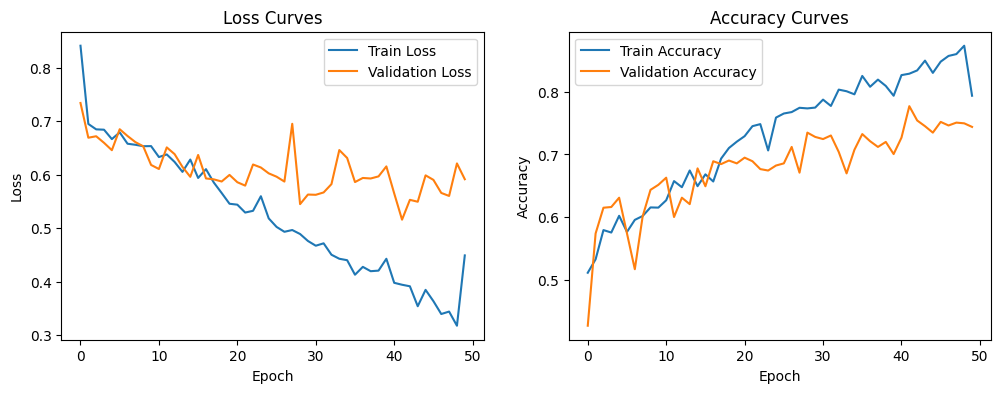

In [23]:

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()


In [24]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing'):
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')


Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Test Accuracy: 0.7198


Testing:   0%|          | 0/7 [00:00<?, ?it/s]

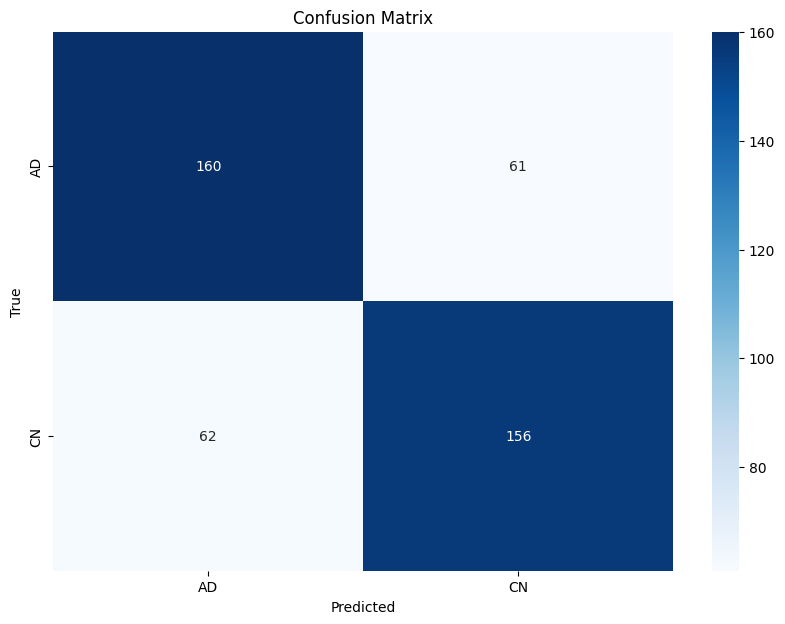

Test Accuracy: 0.7198
Number of false negatives: 62


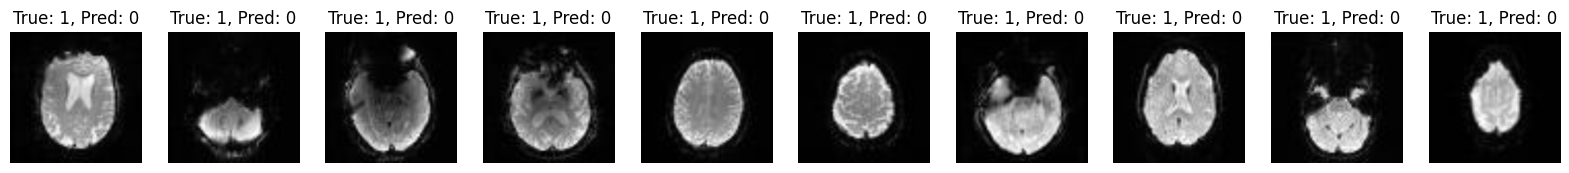

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing'):
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['AD', 'CN'], yticklabels=['AD', 'CN'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

false_negatives = []
for i in range(len(all_labels)):
    if all_predictions[i] == 0 and all_labels[i] == 1:
        false_negatives.append(i)

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')

print(f'Number of false negatives: {len(false_negatives)}')

if len(false_negatives) > 0:
    fig, axes = plt.subplots(1, min(len(false_negatives), 10), figsize=(20, 5))
    for i, index in enumerate(false_negatives[:10]):
        axes[i].imshow(test_loader.dataset[index][0].squeeze(), cmap='gray')
        axes[i].set_title(f'True: {all_labels[index]}, Pred: {all_predictions[index]}')
        axes[i].axis('off')
    plt.show()